<a href="https://colab.research.google.com/github/DungDuc/TableSegNet/blob/main/TableSegNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, you could:

1. Access the data and models from the following link: https://bit.ly/3D1TNLJ

2. Copy data and checkpoints files to your system, e.g. Google Drive.

3. Use the data and models for testing or re-experiment, e.g. mount the Google Drive and run the following cells on Google Colab.

Reference:

https://github.com/GeorgeSeif/Semantic-Segmentation-Suite

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# import library
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, ZeroPadding2D, Concatenate
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation, ReLU, Dense
from tensorflow.keras.layers import Add, Multiply, Reshape, DepthwiseConv2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import Sequence
from sklearn.metrics import precision_score, recall_score, f1_score, \
    confusion_matrix, classification_report, accuracy_score

import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os
import cv2


In [12]:
# TabSegNet implementation with Tensorflow
#NormType = 'batch'
NormType = 'instance' # default
DropRate = 0.2

def TableSegNet(input_shape, num_classes, seg_layers=3, detect_layers=6, first_filters=16):
    print('Build TableSegNet: input shape = ', input_shape, ', num_classes = ', num_classes)
    
    # input
    inputs = Input(shape=input_shape)
    
    # detection path
    ext_layers = detect_layers - seg_layers
    x_detect   = FeatExtractor(inputs, layers=seg_layers, ext_layers=ext_layers, filters=first_filters)
    
    # detection map
    out_detect = Conv2D(num_classes+1, 3, strides=1, padding='same')(x_detect) # foreground and background
    out_detect = Activation('softmax', name="y_detect")(out_detect)
    
    # refinement path
    x_seg = FeatExtractor(inputs, layers=seg_layers, ext_layers=0, filters=first_filters)

    # fusion of detection and segmentation maps
    x_detect = UpScaling(x_detect, 2)
    x = Concatenate()([x_detect, x_seg])
    x = ConvBlock(x, first_filters, stride=1, nConvs=2)
    
    out_seg = Conv2D(2*num_classes+1, 3, strides=1, padding='same')(x) # (table + border) + background

    # final segmentation map
    out_seg = UpScaling(out_seg, 2**seg_layers)
    out_seg = Activation('softmax', name="y_seg")(out_seg)
    
    return Model(inputs=inputs, outputs=[out_seg, out_detect])

def FeatExtractor(x, layers=3, ext_layers=0, filters=16, pool_max=True):
    # convolutional blocks
    for i in range(layers):
        if i < layers-1 or ext_layers > 0: # not the last block
            x = ConvBlock(x, filters, kernel_size=3, stride=1, nConvs=2)
        else: # last block, using three types of kernels
            x0 = ConvBlock(x, filters//2, kernel_size=(3,3), stride=1, nConvs=2)
            x1 = ConvBlock(x, filters//2, kernel_size=(7,3), stride=1, nConvs=2)
            x2 = ConvBlock(x, filters//2, kernel_size=(3,7), stride=1, nConvs=2)
            x  = Concatenate()([x0, x1, x2])
            x  = ConvBlock(x, filters, kernel_size=(1,1), stride=1, nConvs=1)
        if pool_max:
          x = MaxPooling2D()(x)
        else:
          x = AveragePooling2D()(x)
        filters *= 2 # double number of filters
    
    # extra layers
    if ext_layers > 0:
        ExtFeats = []
        x0 = x
        for i in range(ext_layers):
            x1 = ConvBlock(x0, filters//2, kernel_size=(7,3), stride=1, nConvs=2)
            x2 = ConvBlock(x0, filters//2, kernel_size=(3,7), stride=1, nConvs=2)
            x0 = ConvBlock(x0, filters//2, kernel_size=(3,3), stride=1, nConvs=2)
            x0  = Concatenate()([x0, x1, x2])
            x0  = ConvBlock(x0, filters, kernel_size=(1,1), stride=1, nConvs=1)
            if pool_max:
              x0 = MaxPooling2D()(x0)
            else:
              x0 = AveragePooling2D()(x0)
            if i == 0:
              ExtFeats.append(x0)
            else:
              ExtFeats.append(UpScaling(x0, 2**i))
        
        # concate features
        x = Concatenate()(ExtFeats)
        x = ConvBlock(x, filters, kernel_size=(1,1), stride=1, nConvs=1)
    
    return x

# Conv. block
def ConvBlock(x, filters, kernel_size=3, stride=2, nConvs=2):
    # first conv
    x = Conv_BN_Act(filters, kernel_size=kernel_size, stride=stride)(x) # using input stride
    # stride 1 convs
    for i in range(1, nConvs):
      x = Conv_BN_Act(filters, kernel_size=kernel_size, stride=1)(x)
    
    return x

# Convolution block, using batch/instance normalization
def Conv_BN_Act(filters, kernel_size=3, stride=1):
    out = Sequential()
    # conv
    out.add(Conv2D(filters, kernel_size, strides=stride, padding='same', use_bias=False))
    # norm
    if NormType.lower() == 'batch':
        out.add(BatchNormalization())
    elif NormType.lower() == 'instance':
        out.add(InstanceNormalization())
    # activation
    out.add(ReLU())
    # drop
    if DropRate > 0.0:
        out.add(Dropout(DropRate))
    
    return out

def UpScaling(x,scale):
    x = tf.keras.layers.UpSampling2D(size=[scale,  scale], interpolation='bilinear')(x)
    return x

class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""
  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


In [ ]:
# build TableSegNet
num_classes = 1 # for table detection
input_shape = [768, 640, 1]

model = TableSegNet(input_shape, num_classes, seg_layers=3, detect_layers=6, first_filters=32)

model.summary()
#tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes=True)

Build TableSegNet: input shape =  [768, 640, 1] , num_classes =  1
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 640, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 768, 640, 32) 352         input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 768, 640, 32) 9280        sequential[0][0]                 
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 384, 320, 32) 0           sequential_1[0][0]               
___________________________

In [4]:
# API
# data normalization
Norm = lambda x: np.float32(x)/255.0

# data loading
def LoadH5Folders(DataFolders, MaxLen=0):
    X, Y = [], []
    count = 0
    for folder in DataFolders:
      h5Files = glob.glob(folder + '/*.h5')
      h5Files.sort()
      for fn in h5Files:
        x, y = LoadFileH5(fn)
        count += len(x)
        if x is not None:
            X.append(x)
            Y.append(y)
        
        if MaxLen > 0 and count > MaxLen:
          break
      
    if len(X) > 0:
      X = np.vstack(X)
      Y = np.vstack(Y)
      if MaxLen > 0 and len(X) > MaxLen:
        X = X[0:MaxLen]
        Y = Y[0:MaxLen]
    
    return X, Y

def LoadFileH5(h5File):
    print(h5File)
    with h5py.File(h5File, 'r') as f:
        x = f['input'][:]
        y = f['output'][:]
        return x, y
    return None, None

# class labels and colors 
AllTags = ['Reg1', 'Reg2', 'Reg3',\
        'Reg4', 'Reg5', 'Reg6',\
        'Reg7', 'Reg8', 'Reg9']

Colors = [[255,0,0], [0,255,0], [0,0,255],\
          [255,255,0], [255,0,255], [0,255,255],\
          [128,0,0], [0,128,0], [0,0,128],\
          [255,255,255]]
MaxColor = len(Colors)-1

def set_label(Tags):
    # class name and colors
    nColor = len(Colors)
    for i in range(len(Tags)):
        class_names.append(Tags[i])
        label_values.append(Colors[i%nColor])
    # background
    class_names.append('Background')
    label_values.append([255,255,255])

class_names, label_values = [],[]
set_label(AllTags)    

# one-hot and colour coding
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1).astype(np.uint16)
    return x
    
def colour_code_segmentation(img, MaxClass=0):
    image = img.copy()
    colour_codes = np.array(label_values).astype(np.uint8)
    if MaxClass > 0:
      image[image==MaxClass] = MaxColor
    x = colour_codes[image.astype(np.uint16)]
    return x

def ViewImgs(Imgs):
    fig = plt.figure(figsize=(15, 15))
    for i in range(len(Imgs)):
        plt.subplot(1, len(Imgs), i+1)
        if Imgs[i].ndim == 3:
            if  Imgs[i].shape[-1] == 3:
              plt.imshow(Imgs[i])
            else:
              plt.imshow(Imgs[i][...,0], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(Imgs[i], cmap='gray', vmin=0, vmax=255)
    plt.show()


In [ ]:
# data folders
ICDAR19_Train = 'gdrive/MyDrive/Experiment/TableSegNet/Data/ICDAR19/Train'
ICDAR19_Test  = 'gdrive/MyDrive/Experiment/TableSegNet/Data/ICDAR19/Test'
ICDAR19_Ext   = 'gdrive/MyDrive/Experiment/TableSegNet/Data/ICDAR19Ext'

ICDAR13_Train = 'gdrive/MyDrive/Experiment/TableSegNet/Data/ICDAR13/Train'
ICDAR13_Test  = 'gdrive/MyDrive/Experiment/TableSegNet/Data/ICDAR13/Test'

# ICDAR19 model
#XTrain, YTrain = LoadH5Folders([ICDAR19_Train]) 
XTest,  YTest  = LoadH5Folders([ICDAR19_Test])

# ICDAR19+ model
#XTrain, YTrain = LoadH5Folders([ICDAR19_Ext]) 
#XTest,  YTest  = LoadH5Folders([ICDAR19_Test])

# ICDAR13+ model
#XTrain, YTrain = LoadH5Folders([ICDAR19_Ext])
#XVal, YVal = LoadH5Folders([ICDAR13_Train])
#XTest,  YTest  = LoadH5Folders([ICDAR13_Test])

#print('XTrain: ', XTrain.shape, '; YTrain: ', YTrain.shape)
print('XTest:  ', XTest.shape,  '; YTest:  ', YTest.shape)


gdrive/MyDrive/Experiment/TableSegNet/Data/ICDAR19/Test/ICDAR19_0.h5
gdrive/MyDrive/Experiment/TableSegNet/Data/ICDAR19/Test/ICDAR19_1.h5
XTest:   (240, 768, 640, 3) ; YTest:   (240, 768, 640)


In [5]:
# input tensor - grayscale image
def FeatImg(ImgIn):
    gray = cv2.cvtColor(ImgIn, cv2.COLOR_RGB2GRAY)
    return np.stack([gray], axis=-1)


In [ ]:
#XTrain = np.stack([FeatImg(x) for x in XTrain])
#XVal = np.stack([FeatImg(x) for x in XVal])
XTest = np.stack([FeatImg(x) for x in XTest])
#print('Train: ', XTrain.shape, YTrain.shape)
#print('Val: ', XVal.shape, YVal.shape)
print('Test:  ', XTest.shape, YTest.shape)


Test:   (240, 768, 640, 1) (240, 768, 640)


In [6]:
# label augmentation
tab_margin = 16
def LabelAug(y, margin=tab_margin):
    # select foreground
    y0 = ((y==0)*255).astype('uint8')
    
    # border class construction
    kernel = np.ones((margin,margin),np.uint8)
    y_center = cv2.erode(y0,kernel)
    y_extend = cv2.dilate(y0,kernel)

    y_seg = np.stack([y_center, y_extend-y_center, 255-y_extend], axis=-1)
    y_detect = np.stack([y_extend, 255-y_extend], axis=-1)

    return y_seg, y_detect


# data augmentation
bAugFlip = False
bAugScale = True

def DataAug(x, y):
    # flip
    if bAugFlip and np.random.randint(0,2):
        x, y = ImgFlip(x,y)
    # scale
    if bAugScale and np.random.randint(0,2):
        y = np.expand_dims(y, axis=-1)
        x, y = ImgScale(x,y)
        y = y[...,0]
        y = np.uint8(y)
    return x, y

def ImgFlip(x0,y0):
  return np.fliplr(x0), np.fliplr(y0)

def ImgScale(x0, y0):
    scale = 1 + tf.random.uniform(()) / 4  # [0,0.25)
    if 0.95 < scale < 1.05:
        return x0, y0  # do nothing
    
    xh, xw, xd = x0.shape
    yh, yw, yd = y0.shape
    h1, w1 = int(xh * scale), int(xw * scale)
    x0 = tf.image.resize(x0, (h1, w1), method='nearest')
    y0 = tf.image.resize(y0, (h1, w1), method='nearest')

    xy = tf.concat([x0, y0], axis=-1)
    xy = tf.image.random_crop(xy, size=[xh, xw, xd + yd])

    return xy[..., 0:xd], xy[..., xd:]


In [7]:
# API for test
def TestModel(model, X, Y, nClass=1, thresh=0.6):
    print("Testing...")
    (nData, IMG_H, IMG_W, nFeat) = X.shape

    ACC, F1, IOU = 0.0, 0.0, 0.0
    nPositive = np.zeros(nClass)
    nPredicted = np.zeros(nClass)
    nTruePos = np.zeros(nClass)
    count = 0
    for i in range(nData):
        # data
        x, y = X[i], Y[i]
        x0 = x
        x = Norm(x)
        x = np.expand_dims(x, axis=0)
        y_seg, y_detect = LabelAug(y)
        # predict
        yy_seg, yy_detect = model.predict(x)
        yy_seg = yy_seg[0]
        yy_detect = yy_detect[0]
    
        # pixel_level performance
        label_code  = reverse_one_hot(y_seg)
        output_code = reverse_one_hot(yy_seg)
        accuracy, class_accuracies, prec, rec, f1, iou = evaluate_segmentation(pred=output_code, label=label_code, num_classes=nClass)
        ACC += accuracy
        F1 += f1
        IOU += iou
        count += 1

        # detection performance
        GTRegions = GetRegionsGT(y, nClass)
        PDRegions = GetRegionsPD(yy_seg, 0, 1) # one-class detection
        
        TPRegs, nPos, nPred, nTP = MatchRegs(GTRegions, PDRegions, nClass, thresh)
        print(i, nPos, nPred, nTP)
        nPositive += nPos
        nPredicted += nPred
        nTruePos += nTP
        
        # inspect result
        if nTP[0] != nPos[0] or nTP[0] != nPred[0]:
            xRGB = cv2.cvtColor(x0, cv2.COLOR_GRAY2RGB)
            xRGB2 =xRGB.copy()
            for rg in GTRegions:
              cv2.rectangle(xRGB, (rg.xmin, rg.ymin), (rg.xmax, rg.ymax), (0, 0, 255), 3)
            for rg in PDRegions:
              cv2.rectangle(xRGB2, (rg.xmin, rg.ymin), (rg.xmax, rg.ymax), (255, 0, 0), 2)

            ViewImgs([xRGB, xRGB2])

    # end of for
    if count > 0:
        print('Accuracy, F1, IOU: ', ACC/count, F1/count, IOU/count)
        print(nPositive, nPredicted, nTruePos)
        
        Recall = nTruePos/nPositive
        Precision = nTruePos/nPredicted
        F1  = []
        for i in range(len(Precision)):
          F1.append(2*Precision[i]*Recall[i]/(Precision[i] + Recall[i]) if Precision[i] + Recall[i] > 0 else 0)
        
        print("Class: Recall, Precision, F1")
        for i in range(nClass):
            print("%s: %.4f, %.4f, %.4f" % (class_names[i], Recall[i], Precision[i], F1[i]))
# end of Test

# segmentation evaluation
def evaluate_segmentation(pred, label, num_classes, score_averaging="weighted"):
    flat_pred = pred.flatten()
    flat_label = label.flatten()
    
    global_accuracy = compute_global_accuracy(flat_pred, flat_label)
    class_accuracies = compute_class_accuracies(flat_pred, flat_label, 2*num_classes+1)

    prec = precision_score(flat_pred, flat_label, average=score_averaging)
    rec = recall_score(flat_pred, flat_label, average=score_averaging)
    f1 = f1_score(flat_pred, flat_label, average=score_averaging)

    iou = compute_mean_iou(flat_pred, flat_label)

    return global_accuracy, class_accuracies, prec, rec, f1, iou

# Compute the average segmentation accuracy across all classes
def compute_global_accuracy(pred, label):
    total = len(label)
    count = 0.0
    for i in range(total):
        if pred[i] == label[i]:
            count = count + 1.0
    return float(count) / float(total)

# Compute the class-specific segmentation accuracy
def compute_class_accuracies(pred, label, num_classes):
    total = []
    for val in range(num_classes):
        total.append((label == val).sum())

    count = [0.0] * num_classes
    for i in range(len(label)):
        if pred[i] == label[i]:
            count[int(pred[i])] = count[int(pred[i])] + 1.0

    # If there are no pixels from a certain class in the GT, 
    # it returns NAN because of divide by zero
    # Replace the nans with a 1.0.
    accuracies = []
    for i in range(len(total)):
        if total[i] == 0:
            accuracies.append(1.0)
        else:
            accuracies.append(count[i] / total[i])

    return accuracies


def compute_mean_iou(pred, label):
    unique_labels = np.unique(label)
    num_unique_labels = len(unique_labels);
    I = np.zeros(num_unique_labels)
    U = np.zeros(num_unique_labels)
    for index, val in enumerate(unique_labels):
        pred_i = pred == val
        label_i = label == val
        I[index] = float(np.sum(np.logical_and(label_i, pred_i)))
        U[index] = float(np.sum(np.logical_or(label_i, pred_i)))

    mean_iou = np.mean(I / U)
    return mean_iou

# detection evaluation
class Region(object):
    def __init__(self, tag = None, xmin=None, ymin=None, xmax=None, ymax=None, poly=None):
        self.tag = tag
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.poly = poly
    def iou(self, other):
        if self.poly is not None and other.poly is not None:
            return poly_iou(self.poly, other.poly)
        else:
            return 0


# match regions 
def MatchRegs(GTRegs, PDRegs, nClass, thresh):
  TPRegs = []
  for reg in PDRegs:
    if Match(reg, GTRegs, thresh):
      TPRegs.append(reg)
  
  nPos = np.zeros(nClass)
  nPD = np.zeros(nClass)
  nTP = np.zeros(nClass)
  for i in range(nClass):
    nPos[i] = len([r for r in GTRegs if int(r.tag) == i])
    nPD[i]  = len([r for r in PDRegs if int(r.tag) == i])
    nTP[i]  = len([r for r in TPRegs if int(r.tag) == i])

  return TPRegs, nPos, nPD, nTP

def Match(rg, Regs, thresh):
  for reg in Regs:
    if rg.tag == reg.tag and bb_iou(rg, reg) >= thresh:
      return True
  return False

def bb_iou(regA, regB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(regA.xmin, regB.xmin)
	yA = max(regA.ymin, regB.ymin)
	xB = min(regA.xmax, regB.xmax)
	yB = min(regA.ymax, regB.ymax)
 
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
 
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (regA.xmax - regA.xmin + 1) * (regA.ymax - regA.ymin + 1)
	boxBArea = (regB.xmax - regB.xmin + 1) * (regB.ymax - regB.ymin + 1)
 
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
 
	# return the intersection over union value
	return iou

def poly_iou(tbl1, tbl2):
  tbl1 = np.squeeze(tbl1)
  tbl2 = np.squeeze(tbl2)
  a = Polygon(tbl1)
  b = Polygon(tbl2)
  if a.is_valid and b.is_valid:
    return a.intersection(b).area / a.union(b).area
  else:
    return 0

# ground truth regions
def GetRegionsGT(CodeImg, nClass):
  regions = []
  for i in range(nClass):
    reg_img = np.uint8((CodeImg == i))*255
    contours, _ = cv2.findContours(reg_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
      (x,y,w,h) = cv2.boundingRect(cnt)
      regions.append(Region(str(i), x, y, x+w, y+h, cnt))
  
  return regions

# predicted regions
def GetRegionsPD(yy, classID, borderID):
    # get regions
    label = np.argmax(yy, axis=-1)
    regions = GetRegions(label==classID, label==borderID)
    # class ID and process border
    for i in range(len(regions)):
      regions[i].tag = str(classID)
      regions[i].xmin -= tab_margin // 2
      regions[i].ymin -= tab_margin // 2
      regions[i].xmax += tab_margin // 2
      regions[i].ymax += tab_margin // 2
    
    return regions

def GetRegions(yy, yy_border, min_w=100, min_h=8, split_thresh=0.6):
    region_bw = np.uint8(yy*255)
    border_bw = np.uint8(yy_border*255)
    # find regions
    regions = []
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(region_bw)
    img_h, img_w = region_bw.shape[0], region_bw.shape[1]
    for i in range(1,nlabels):
        l, t = stats[i,cv2.CC_STAT_LEFT], stats[i,cv2.CC_STAT_TOP]
        w, h = stats[i,cv2.CC_STAT_WIDTH], stats[i,cv2.CC_STAT_HEIGHT]
        r, b = l+w, t+h
 
        # check and get sub-regions
        if w >= min_w and h >= min_h and stats[i,cv2.CC_STAT_AREA] > 0.6*w*h:
            HRegs = SplitRegions(l,t,r,b, region_bw, border_bw, split_thresh, True, min_w, min_h)
            for reg in HRegs:
              VRegs = SplitRegions(reg.xmin, reg.ymin, reg.xmax, reg.ymax, region_bw, border_bw, split_thresh, False, min_w, min_h)
              regions.extend(VRegs)

    return regions


def SplitRegions(left, top, right, bottom, region_bw, border_bw, split_thresh, Horiz=True, min_w=50, min_h=8):
    # extended region
    img_h, img_w = region_bw.shape[0], region_bw.shape[1]
    m = tab_margin
    if Horiz:
      top, bottom = np.maximum(0, top-m), np.minimum(img_h, bottom+m)
    else:
      left, right = np.maximum(0, left-m), np.minimum(img_w, right+m)
    width, height = right-left, bottom-top
    
    # histogram
    roi_region = region_bw[top:bottom, left:right, ...]
    roi_border = border_bw[top:bottom, left:right, ...]
    if Horiz:
      hist_region = np.sum(roi_region/255,axis=1)
      hist_border = np.sum(roi_border/255,axis=1)
    else:
      hist_region = np.sum(roi_region/255,axis=0)
      hist_border = np.sum(roi_border/255,axis=0)
    
    # thersholds
    s, e = 0, len(hist_region)-1
    MaxVal = np.max(hist_region)
    split_thresh = split_thresh*MaxVal
    
    # split and adjust
    regions = []
    i = s
    while i < e:
        # find border
        while i < e and hist_border[i] <= split_thresh:
          i += 1
        # skip blank
        while i < e and hist_region[i] <= split_thresh:
          i += 1

        if i >= e:
          break # no region
        
        # find next border
        i += 1
        start = i
        while i < e and hist_border[i] <= split_thresh:
          i += 1
        if i >= e:
          break # no border
        
        end = i
        # rool back
        while end > start and hist_region[end] <= split_thresh:
          end -= 1

        # get line/column
        if Horiz:
          ll,tt,rr,bb = left,top+start,right,top+end
        else:
          ll,tt,rr,bb = left+start,top,left+end,bottom
        
        if bb - tt >= min_h and rr - ll >= min_w:
          reg = Region('0', ll, tt, rr, bb, None)
          regions.append(reg)
    # end of while 
    return regions

# visualize region evaluation
def SampleEval(model, x, y, nClass, thresh=0.6):
    x0 = x
    x = Norm(x)
    x = np.expand_dims(x, axis=0)
    y_seg, y_detect = LabelAug(y)
    # predict
    yy_seg, yy_detect = model.predict(x)
    yy_seg, yy_detect = yy_seg[0], yy_detect[0]

    # output value
    yy_table = np.uint8(yy_seg[...,0]*255)
    yy_border = np.uint8(yy_seg[...,1]*255)
    #yy_bg = np.uint8(yy_seg[...,2]*255)
 
    # output color
    label_code  = reverse_one_hot(y_seg)
    output_code = reverse_one_hot(yy_seg)
    label_img  = colour_code_segmentation(label_code, MaxClass=2)
    output_img = colour_code_segmentation(output_code, MaxClass=2)
    
    # pixel performance
    accuracy, class_accuracies, prec, rec, f1, iou = evaluate_segmentation(pred=output_code, label=label_code, num_classes=nClass)
    print('IOU: ', iou)

    # detection performance
    GTRegions = GetRegionsGT(y, nClass)
    PDRegions = GetRegionsPD(yy_seg, 0, 1)
    
    TPRegs, nPos, nPred, nTP = MatchRegs(GTRegions, PDRegions, nClass, thresh)
    print('nPos, nPred, nTP:')
    print(nPos, nPred, nTP)

    # view
    xRGB = cv2.cvtColor(x0, cv2.COLOR_GRAY2RGB)
    xRGB2 =xRGB.copy()
    for rg in GTRegions:
      cv2.rectangle(xRGB, (rg.xmin, rg.ymin), (rg.xmax, rg.ymax), (0, 0, 255), 3)
    for rg in PDRegions:
      cv2.rectangle(xRGB2, (rg.xmin, rg.ymin), (rg.xmax, rg.ymax), (255, 0, 0), 2)

    #ViewImgs([xRGB, yy_table, yy_border, xRGB2])#, yy_bg])
    ViewImgs([xRGB, xRGB2])

def DataGenAux(X, Y, scale=4, size=1, AugFunt=None):
    nData = X.shape[0]
    h, w = X.shape[1], X.shape[2]
    scale = 2 ** scale

    ids = np.random.permutation(nData)
    i = 0
    while True:
        # permute data
        if i + size > nData:
            ids = np.random.permutation(nData)
            i = 0
        # select data
        bx, by, ba = [], [], []
        for j in range(size):
            x0, y0 = X[ids[i + j]], Y[ids[i + j]]
            if AugFunt:
                x0, y0 = AugFunt(x0, y0)
            bx.append(x0)

            y, ya = LabelAug(y0)
            by.append(y)
            ba.append(ya)

        # batch
        bx, by, ba = np.asarray(bx), np.asarray(by), np.asarray(ba)
        ba = tf.image.resize(ba, (h // scale, w // scale))
        i += size

        # int to float
        bx = Norm(bx)
        by = Norm(by)
        ba = Norm(ba)

        yield (bx, {'y_seg': by, 'y_detect': ba})

def LabelAug(y, margin=16):
    y0 = ((y == 0) * 255).astype('uint8')

    kernel = np.ones((margin, margin), np.uint8)
    y_center = cv2.erode(y0, kernel)
    y_extend = cv2.dilate(y0, kernel)

    y1 = np.stack([y_center, y_extend - y_center, 255 - y_extend], axis=-1)
    y2 = np.stack([y_extend, 255 - y_extend], axis=-1)

    return y1, y2


In [ ]:
Ckpts_Path = 'gdrive/MyDrive/Experiment/TableSegNet/Models'

ModelName = 'ICDAR19'
#ModelName = 'ICDAR19Plus'
#ModelName = 'ICDAR13Plus'

model.load_weights(Ckpts_Path + '/' + ModelName)

IOU:  0.9330478051725941
nPos, nPred, nTP:
[2.] [2.] [2.]


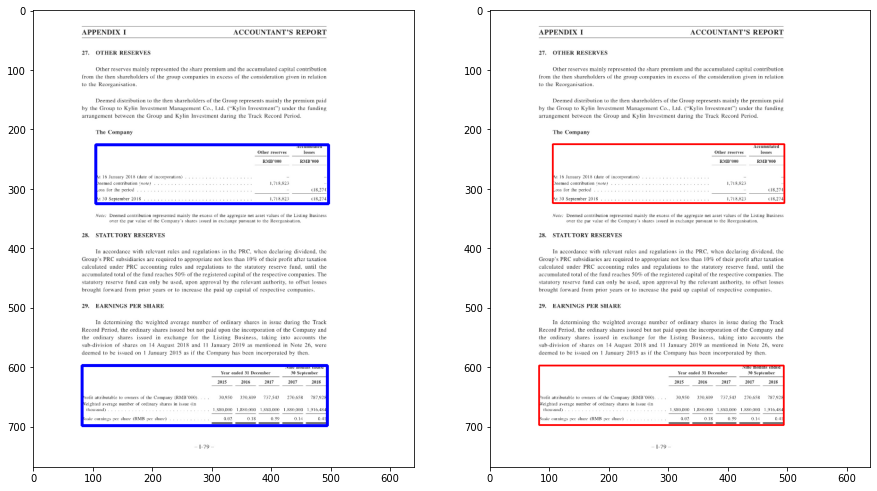

In [ ]:
# view sample prediction
id = 0
SampleEval(model, XTest[id], YTest[id], num_classes, thresh=0.6)

In [ ]:
TestModel(model, XTest, YTest, 1, thresh=0.6)

In [9]:
def Train(XTrain, YTrain, ModelName, XVal=None, YVal=None, XTest=None, YTest=None, SecondPhase=True):
    # data shape
    nDataTrain, IMG_H, IMG_W, IMG_C = XTrain.shape
    num_classes = np.max(YTrain)
    input_shape = [IMG_H, IMG_W, IMG_C]

    # build the model
    model = TableSegNet(input_shape, num_classes, seg_layers=3, detect_layers=6, first_filters=32)
    model.summary()

    Opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    Losses = {
        "y_seg": "categorical_crossentropy",
        "y_detect": "categorical_crossentropy",
    }
    lossWeights = {"y_seg": 1.0, "y_detect": 0.3}
    model.compile(optimizer=Opt, loss=Losses, loss_weights=lossWeights, metrics=['accuracy'])

    # train parameters
    EPOCHS = 100
    BATCH_SIZE = 2
    Checkpoint = ModelCheckpoint('Ckpts/' + ModelName, monitor='val_y_seg_accuracy', mode='max', save_weights_only=True,
                                  save_best_only=True, verbose=1)

    # first phase
    if XVal is not None:
        nDataVal = XVal.shape[0]
        H = model.fit(DataGenAux(XTrain, YTrain, scale=4, size=BATCH_SIZE, AugFunt=DataAug),
                      steps_per_epoch=nDataTrain // BATCH_SIZE, epochs=EPOCHS,
                      validation_data=DataGenAux(XVal,  YVal,  scale=4, size=1),
                      validation_steps=nDataVal, validation_freq=1,
                      callbacks=[Checkpoint], verbose=1)

    # second phase
    
    if XVal is None or SecondPhase:
        ROUNDS = 1
        nFold = 3
        nVal_k = nDataTrain // nFold
        EPOCHS = 50

        for r in range(ROUNDS):
            for k in range(nFold):
                XVal_k, YVal_k = XTrain[nVal_k*k:nVal_k*(k+1), ...], YTrain[nVal_k*k:nVal_k*(k+1), ...]
                H = model.fit(DataGenAux(XTrain, YTrain, scale=4, size=BATCH_SIZE, AugFunt=DataAug),
                              steps_per_epoch=nDataTrain // BATCH_SIZE, epochs=EPOCHS,
                              validation_data=DataGenAux(XVal_k,  YVal_k,  scale=4, size=1),
                              validation_steps=nVal_k, validation_freq=1,
                              callbacks=[Checkpoint], verbose=1)

    # test
    if XTest is not None:
        TestModel(model, XTest, YTest, num_classes, thresh=0.9)


In [ ]:
ICDAR19_Train = 'gdrive/MyDrive/Experiment/TableSegNet/Data/ICDAR19/Train'
ICDAR19_Test  = 'gdrive/MyDrive/Experiment/TableSegNet/Data/ICDAR19/Test'

# ICDAR19 model
XTrain, YTrain = LoadH5Folders([ICDAR19_Train]) 
XTest,  YTest  = LoadH5Folders([ICDAR19_Test])

# RGB -> grayscale
XTrain = np.stack([FeatImg(x) for x in XTrain])
XTest = np.stack([FeatImg(x) for x in XTest])

Train(XTrain, YTrain, 'ICDAR19 Model', XTest=XTest, YTest=YTest)